# Import Packages

In [91]:
import matplotlib.pyplot as plt
from utils import create_dataset,model_plot,history_plot,prepare_dataset
import glob 
import numpy as np
import os
import random
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2 
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model

In [56]:
df = pd.read_csv('../datasets/yt_subscribers.csv')
print(df.head(10))

         Date  Subscribers  Unnamed: 2  Unnamed: 3  Unnamed: 4
0   8/26/2024           40         NaN         NaN         NaN
1  10/13/2024           39         NaN         NaN         NaN
2   3/28/2024           38         NaN         NaN         NaN
3   8/25/2024           38         NaN         NaN         NaN
4   7/18/2024           37         NaN         NaN         NaN
5   9/16/2024           36         NaN         NaN         NaN
6   8/10/2024           34         NaN         NaN         NaN
7   7/26/2024           33         NaN         NaN         NaN
8    9/1/2024           33         NaN         NaN         NaN
9   11/4/2024           33         NaN         NaN         NaN


In [57]:
df['Date'] = pd.to_datetime(df['Date'])

In [58]:
clean_df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])
print(clean_df.head(10))

        Date  Subscribers
0 2024-08-26           40
1 2024-10-13           39
2 2024-03-28           38
3 2024-08-25           38
4 2024-07-18           37
5 2024-09-16           36
6 2024-08-10           34
7 2024-07-26           33
8 2024-09-01           33
9 2024-11-04           33


In [59]:
clean_df.sort_values(by='Date', inplace=True)

In [60]:
clean_df.head(10)

,Date,Subscribers
254,2023-11-15,13
336,2023-11-16,8
349,2023-11-17,6
301,2023-11-18,10
215,2023-11-19,15
180,2023-11-20,17
361,2023-11-21,3
337,2023-11-22,8
355,2023-11-23,5
338,2023-11-24,8


In [61]:
clean_df.set_index('Date', inplace=True)

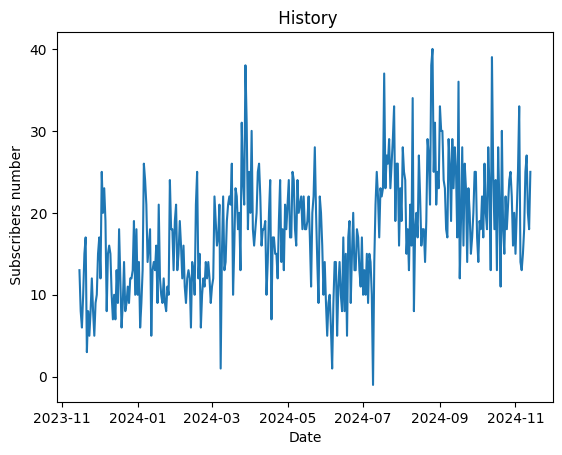

In [62]:
plt.title(' History')
plt.plot(clean_df["Subscribers"])
plt.xlabel('Date')
plt.ylabel(' Subscribers number')
plt.show()

In [63]:
df = np.array(clean_df.iloc[:])
df[:5]

array([[13],
       [ 8],
       [ 6],
       [10],
       [15]], dtype=int64)

## Splitting data

In [39]:
ratio = 0.80

train_size = int(len(df) * ratio)  
test_size = len(df) - train_size 

train_data = df[:train_size]  
test_data = df[train_size:]   

print(f"All data: {len(df)} ")
print(f"Train data: {len(train_data)} ")
print(f"Test data: {len(test_data)} ")


All data: 365 
Train data: 292 
Test data: 73 


## Normalize data

In [64]:
scaler=MinMaxScaler(feature_range=(0,1))
train_data=scaler.fit_transform(train_data)
test_data=scaler.transform(test_data)
train_data.shape, test_data.shape

((292, 1), (73, 1))

In [92]:
def create_dataset(dataset, time_step=1, output=1):
    X, Y = [], []

    for i in range(len(dataset) - time_step - output):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        
        b = dataset[(i + time_step):(i + time_step + output), 0]  
        Y.append(b)
    
    return np.array(X), np.array(Y)

In [276]:
time_step_in=30
time_step_out=30
X_train,y_train=create_dataset(train_data,time_step_in,time_step_out)
X_test,y_test=create_dataset(test_data,time_step_in,time_step_out)
print(f"X_train: {X_train.shape} \ny_train: {y_train.shape}\nX_test: {X_test.shape}\ny_test: {y_test.shape}")

X_train: (232, 30) 
y_train: (232, 30)
X_test: (13, 30)
y_test: (13, 30)


In [277]:
model_1=Sequential()
model_1.add(Dense(256,input_shape=(30,),activation="relu"))
model_1.add(Dense(128,activation="relu"))
model_1.add(Dense(64,activation="relu"))
model_1.add(Dense(32,activation="relu"))
model_1.add(Dense(30))
model_1.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])
model_1.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_77 (Dense)                │ (None, 256)            │         7,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 30)             │           990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,158 (203.74 KB)

 Trainable params: 52,158 (203.74 KB)

 Non-trainable params: 0 (0.00 B)

In [278]:
checkpoint_callback_val = tf.keras.callbacks.ModelCheckpoint(
    'best_loss_val.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

checkpoint_callback_train = tf.keras.callbacks.ModelCheckpoint(
    'best_loss_train.keras',
    monitor='loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

In [279]:
history=model_1.fit(
    X_train,y_train,
    epochs=100,
    validation_data=(X_test,y_test),
    callbacks=[checkpoint_callback_val,checkpoint_callback_train],
    verbose=1

)

Epoch 1/100
1/8 ━━━━━━━━━━━━━━━━━━━━ 4s 678ms/step - loss: 0.4338 - mean_absolute_error: 0.4338
Epoch 1: val_loss improved from inf to 0.32507, saving model to best_loss_val.keras

Epoch 1: loss improved from inf to 0.35851, saving model to best_loss_train.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.3884 - mean_absolute_error: 0.3884 - val_loss: 0.3251 - val_mean_absolute_error: 0.3251
Epoch 2/100
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2569 - mean_absolute_error: 0.2569
Epoch 2: val_loss improved from 0.32507 to 0.26762, saving model to best_loss_val.keras

Epoch 2: loss improved from 0.35851 to 0.25980, saving model to best_loss_train.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2657 - mean_absolute_error: 0.2657 - val_loss: 0.2676 - val_mean_absolute_error: 0.2676
Epoch 3/100
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2370 - mean_absolute_error: 0.2370
Epoch 3: val_loss improved from 0.26762 to 0.22946, saving model to best_loss_val.keras

Epoch 3: lo

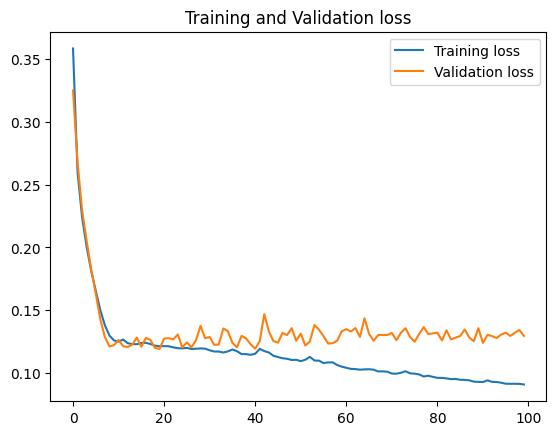

In [280]:
history_plot(history)

In [281]:
train_predicted = model_1.predict(X_train)
test_predicted = model_1.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [282]:
# calculate MAE
mae_error_train= mae(y_train,train_predicted)
mae_error_test= mae(y_test,test_predicted)
print(f"MAE Train data  : {mae_error_train} ")
print(f"MAE  Test data : {mae_error_test} ")

MAE Train data  : 0.08956423664159023 
MAE  Test data : 0.12944300456707594 


In [283]:
x_train_first_7 = X_train[0]
x_train_first_7.shape

(30,)

## N_steps=30 Number_to_shift=7

In [284]:
x_train_first_7 = X_train[0]

def subscribe_forcasting(model, X_train, n_step=1,number_to_shift=-1):
    y_prediction_day = []
    input_window = X_train[0].copy()  

    for i in range(1, n_step + 1):
        print(f"\nStep {i} ==>  Input Window: {input_window}")
        
        try:
            y_temp = model.predict(input_window.reshape(1, -1))  
            print(f"Prediction Output (y_temp): {y_temp} ")
            y_prediction_day.append(y_temp[0][0]) 
            input_window = np.roll(input_window, number_to_shift)  # Roll/shift the window to the left
            input_window[-1] = y_temp[0][0]  # Replace the last element with the new prediction    
        except Exception as e:
            print(f"Error during prediction at Step {i}: {e}")
            break  # Stop the loop if an error occurs
    
    return np.array(y_prediction_day)

predictions = subscribe_forcasting(model_1, X_train, n_step=30,number_to_shift=-7)
print("\nPredicted values for the next steps:", predictions)



Step 1 ==>  Input Window: [0.34146341 0.2195122  0.17073171 0.26829268 0.3902439  0.43902439
 0.09756098 0.2195122  0.14634146 0.2195122  0.31707317 0.2195122
 0.14634146 0.24390244 0.26829268 0.3902439  0.43902439 0.31707317
 0.63414634 0.51219512 0.58536585 0.48780488 0.2195122  0.3902439
 0.41463415 0.3902439  0.26829268 0.19512195 0.26829268 0.19512195]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction Output (y_temp): [[0.3145829  0.2559355  0.31009492 0.31445816 0.18638444 0.25289035
  0.2457887  0.18450196 0.2744608  0.28198427 0.25240192 0.3311508
  0.39526    0.43253878 0.43129674 0.28411135 0.5153548  0.38624355
  0.3820362  0.36993942 0.46051058 0.39913973 0.5984042  0.60665584
  0.5433406  0.49013805 0.44874492 0.45094126 0.37424195 0.4299153 ]] 

Step 2 ==>  Input Window: [0.2195122  0.14634146 0.2195122  0.31707317 0.2195122  0.14634146
 0.24390244 0.26829268 0.3902439  0.43902439 0.31707317 0.63414634
 0.51219512 0.58536585 0.48780488 0.2195122  0.3902439  0.41463415
 0.

In [285]:
x_input = np.array(X_train[0])
y_output = np.array(predictions).reshape(-1)
x_input.shape, y_output.shape

((30,), (30,))

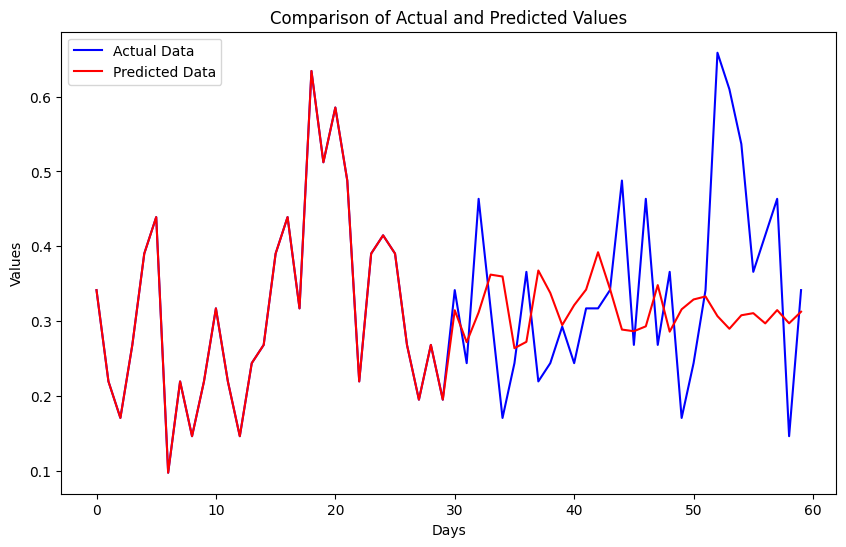

In [286]:
predicted_result = np.concatenate((x_input, y_output))
predicted_result
model_plot(train_data[:60],predicted_result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


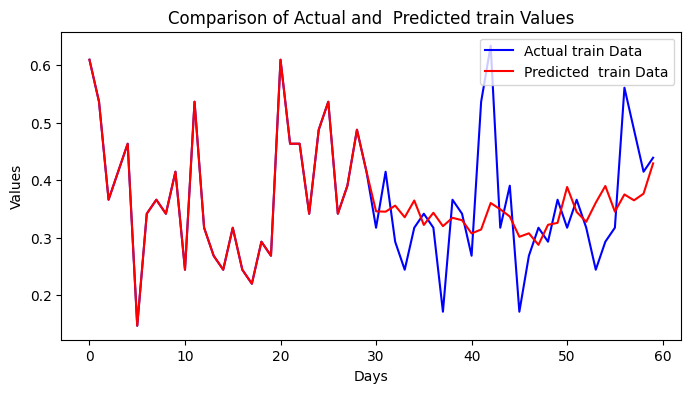

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


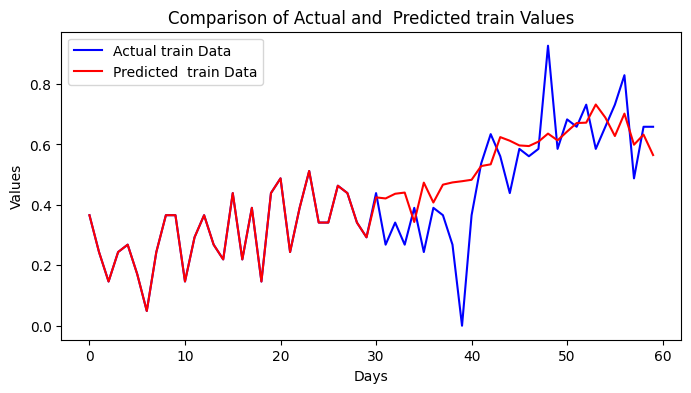

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


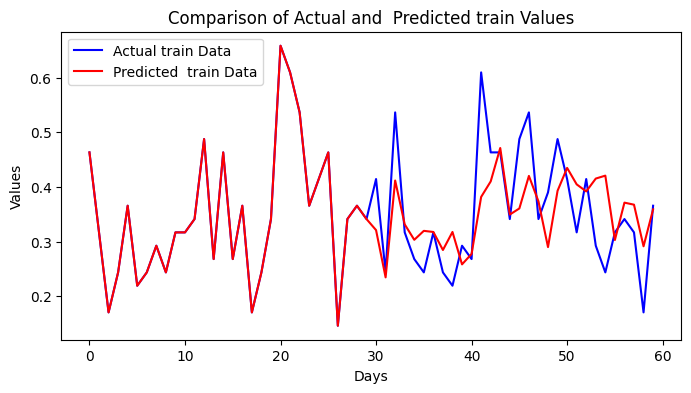

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


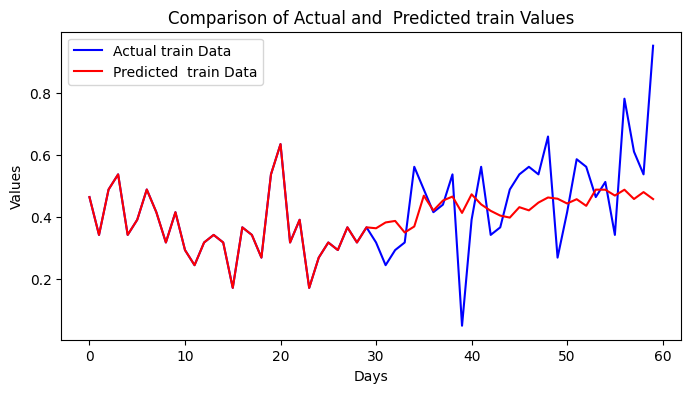

In [287]:
def calculate_random_sequences(n_random, model, X_train):
    for i in range(n_random):
        r = random.randint(0, len(X_train)-30)
        x_temp = X_train[r]
        original_data = list(x_temp)
        for idx in range(1, 31):
            y_next = X_train[r+idx]
            original_data.append(y_next[-1])
        y_temp = model.predict(x_temp.reshape(1, -1))
        x_input = np.array(x_temp)
        y_output = np.array(y_temp).reshape(-1)
        predicted_result = np.concatenate((x_input, y_output))


        plt.figure(figsize=(8, 4))
        plt.plot(original_data, label='Actual train Data', color='blue')
        plt.plot(predicted_result, label='Predicted  train Data', color='red')
        plt.title('Comparison of Actual and  Predicted train Values')
        plt.xlabel('Days')
        plt.ylabel('Values')
        plt.legend()
        plt.show()
calculate_random_sequences(4,model_1,X_train)

## N_step = 30 Number_to_shift = -10

In [288]:
predictions = subscribe_forcasting(model_1, X_train, n_step=30,number_to_shift=-10)
print("\nPredicted values for the next steps:", predictions)


Step 1 ==>  Input Window: [0.34146341 0.2195122  0.17073171 0.26829268 0.3902439  0.43902439
 0.09756098 0.2195122  0.14634146 0.2195122  0.31707317 0.2195122
 0.14634146 0.24390244 0.26829268 0.3902439  0.43902439 0.31707317
 0.63414634 0.51219512 0.58536585 0.48780488 0.2195122  0.3902439
 0.41463415 0.3902439  0.26829268 0.19512195 0.26829268 0.19512195]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction Output (y_temp): [[0.3145829  0.2559355  0.31009492 0.31445816 0.18638444 0.25289035
  0.2457887  0.18450196 0.2744608  0.28198427 0.25240192 0.3311508
  0.39526    0.43253878 0.43129674 0.28411135 0.5153548  0.38624355
  0.3820362  0.36993942 0.46051058 0.39913973 0.5984042  0.60665584
  0.5433406  0.49013805 0.44874492 0.45094126 0.37424195 0.4299153 ]] 

Step 2 ==>  Input Window: [0.31707317 0.2195122  0.14634146 0.24390244 0.26829268 0.3902439
 0.43902439 0.31707317 0.63414634 0.51219512 0.58536585 0.48780488
 0.2195122  0.3902439  0.41463415 0.3902439  0.26829268 0.19512195
 0.2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


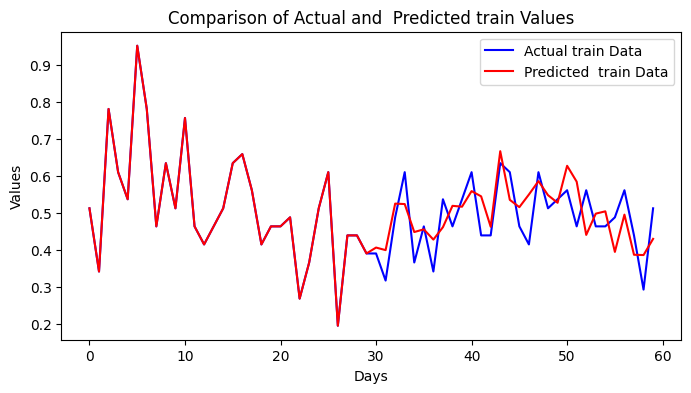

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


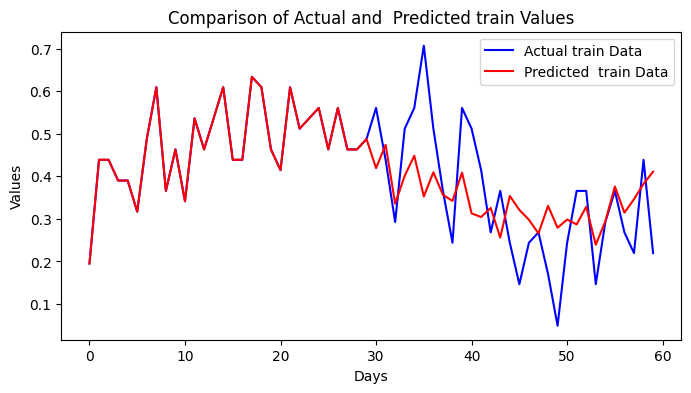

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


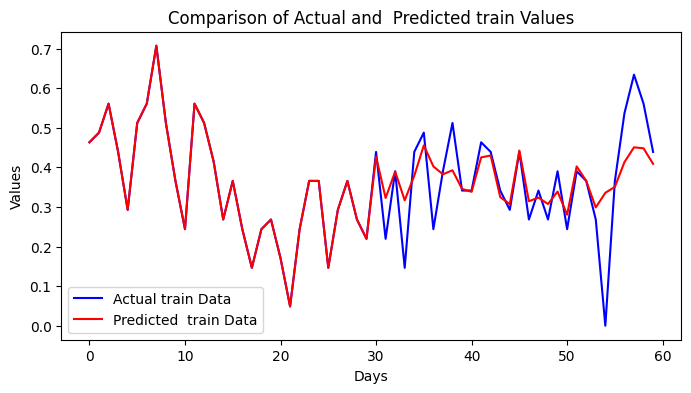

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


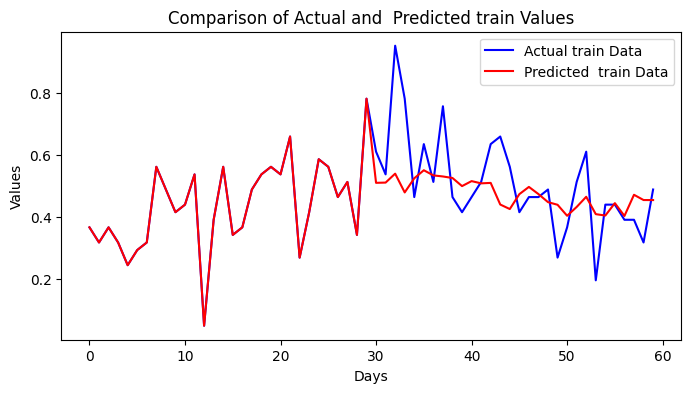

In [289]:
calculate_random_sequences(4,model_1, X_train)